In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import scipy.io as sio
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import hdc

%matplotlib notebook

In [9]:
# location of all offline data
dataDir = './emg_mat/offline/'

baseExperiment = 1
newExperiment = 3

holdStart = 70
holdEnd = 149
D = 10000
numFeat = 320

numIter = 10

numSVM = np.zeros((5,20,numIter))
accSVM = np.zeros((5,20,numIter))
accHDC = np.zeros((5,20,numIter))

# for s in range(5):
for s in [1]:
    # subject labels are 1-indexed
    subject = s + 1
    print('Running Subject ' + str(subject))
    
    # load data from the two contexts
    filename = dataDir + 'S' + str(subject) + 'E' + str(baseExperiment) + '.mat'
    base = sio.loadmat(filename)['emgHD']
    filename = dataDir + 'S' + str(subject) + 'E' + str(newExperiment) + '.mat'
    new = sio.loadmat(filename)['emgHD']
    
    # get metatdata
    numGest, numTrial = base.shape
    numCh = base[0,0][2].shape[1]
    numEx = holdEnd - holdStart + 1
    
    # separate training and testing dataframes
    features = np.empty((numCh*5,0))
    ngrams = np.empty((D,0))
    labels = np.empty(0)
    trials = np.empty(0)
    context = np.empty(0)

    # collect baseline data
    
    for g in range(numGest):
        for t in range(numTrial):
            trial = base[g,t]
            feat = np.empty((0,numEx))
            for i in range(5):
                feat = np.concatenate((feat,trial[2][(holdStart+i):(holdEnd+i+1),:].T),axis=0)
            features = np.concatenate((features,feat),axis=1)
            ngrams = np.concatenate((ngrams,trial[3][:,holdStart:holdEnd+1]),axis=1)
            labels = np.concatenate((labels,g*np.ones(numEx)))
            trials = np.concatenate((trials,t*np.ones(numEx)))
            context = np.concatenate((context,0*np.ones(numEx)))
    # collect new data
    
    for g in range(numGest):
        for t in range(numTrial):
            trial = new[g,t]
            feat = np.empty((0,numEx))
            for i in range(5):
                feat = np.concatenate((feat,trial[2][(holdStart+i):(holdEnd+i+1),:].T),axis=0)
            features = np.concatenate((features,feat),axis=1)
            ngrams = np.concatenate((ngrams,trial[3][:,holdStart:holdEnd+1]),axis=1)
            labels = np.concatenate((labels,g*np.ones(numEx)))
            trials = np.concatenate((trials,t*np.ones(numEx)))
            context = np.concatenate((context,1*np.ones(numEx)))

    # create dataframe for features
    featCols = ['feature' + str(i) for i in range(features.shape[0])]
    featData = pd.DataFrame(features.T,columns=featCols)
    featData['gesture'] = labels
    featData['trial'] = trials
    featData['context'] = context

    # create dataframe for ngrams
    ngramCols = ['hv' + str(i) for i in range(ngrams.shape[0])]
    ngramData = pd.DataFrame(ngrams.T,columns=ngramCols)
    ngramData['gesture'] = labels
    ngramData['trial'] = trials
    ngramData['context'] = context
    
    testPercentage = np.linspace(0.05,1,20)
    for tpIdx,tp in enumerate(testPercentage):
        # iterate through to get averages (cross-validation)
        for n in range(numIter):
            isTest = np.empty(0)
            testTrials = np.random.randint(0,numTrial,numGest)
            for g in range(numGest):
                for t in range(numTrial):
                    if t == testTrials[g]:
                        isTest = np.concatenate((isTest,np.random.permutation(np.concatenate((np.ones(int(round(tp*numEx))), -np.ones(numEx - int(round(tp*numEx))))))))
                    else:
                        isTest = np.concatenate((isTest,np.zeros(numEx)))
            testTrials = np.random.randint(0,numTrial,numGest)
            for g in range(numGest):
                for t in range(numTrial):
                    if t == testTrials[g]:
                        isTest = np.concatenate((isTest,np.random.permutation(np.concatenate((np.ones(int(round(tp*numEx))), -np.ones(numEx - int(round(tp*numEx))))))))
                    else:
                        isTest = np.concatenate((isTest,np.zeros(numEx)))

            featData['isTest'] = isTest
            ngramData['isTest'] = isTest

            # train HD model
            allGest = ngramData['gesture'].unique()
            AM = hdc.Memory(D)
            for g in allGest:
    #             ng = np.asarray(ngramData.loc[(ngramData['gesture'] == g) & (ngramData['isTest'] == 0) & (ngramData['context'] == 0)].iloc[:,0:D])
                ng = np.asarray(ngramData.loc[(ngramData['gesture'] == g) & (ngramData['isTest'] == 1) & (ngramData['context'] == 0)].iloc[:,0:D])
                AM.train(ng,vClass=g,vClust=0)

            for g in allGest:
    #             ng = np.asarray(ngramData.loc[(ngramData['gesture'] == g) & (ngramData['isTest'] == 0) & (ngramData['context'] == 1)].iloc[:,0:D])
                ng = np.asarray(ngramData.loc[(ngramData['gesture'] == g) & (ngramData['isTest'] == 1) & (ngramData['context'] == 1)].iloc[:,0:D])
                AM.train(ng,vClass=g,vClust=1)

            # collect testing data and perform inference
            testNgram = ngramData.loc[(ngramData['isTest'] == 0)].iloc[:,0:D]
            testLabel = ngramData.loc[(ngramData['isTest'] == 0)].iloc[:,D]

            label,sim = AM.match(np.asarray(testNgram),bipolar=True)
            accHDC[s,tpIdx,n] = (label == np.asarray(testLabel)).sum()/len(label)
            acc = accHDC[s,tpIdx,np.nonzero(accHDC[s,tpIdx,:])].mean()
            print('\t HDC Iteration %d: Accuracy = %f'%(n+1,acc))

            # train and test SVM model
            clf = svm.SVC(decision_function_shape='ovo',kernel='linear',C=10)
    #         clf.fit(featData.loc[featData['isTest'] == 0].iloc[:,0:numFeat],featData.loc[featData['isTest'] == 0].iloc[:,numFeat])
            clf.fit(featData.loc[featData['isTest'] == 1].iloc[:,0:numFeat],featData.loc[featData['isTest'] == 1].iloc[:,numFeat])
    #         yhat = clf.predict(featData.loc[featData['isTest'] == 1].iloc[:,0:numFeat])
    #         accSVM[s,n] = accuracy_score(yhat,featData.loc[featData['isTest'] == 1].iloc[:,numFeat])
            yhat = clf.predict(featData.loc[featData['isTest'] == 0].iloc[:,0:numFeat])
            accSVM[s,tpIdx,n] = accuracy_score(yhat,featData.loc[featData['isTest'] == 0].iloc[:,numFeat])
            numSVM[s,tpIdx,n] = len(clf.support_)
            acc = accSVM[s,tpIdx,np.nonzero(accSVM[s,tpIdx,:])].mean()
            num = numSVM[s,tpIdx,np.nonzero(numSVM[s,tpIdx,:])].mean()
            print('\t Iteration %d: SVM Accuracy = %f'%(n+1,acc))
        
# #         # batch train and test LDA model
# #         clf = LinearDiscriminantAnalysis()
# #         clf.fit(Xtrain,ytrain)
# #         yhat = clf.predict(Xtest)
# #         print('\t Iteration %d: Accuracy = %f\r'%(n+1,accuracy_score(yhat,ytest)),end="")
# # #         accSVM[s,n] = accuracy_score(yhat,ytest)
# # #         numSVM[s,n] = len(clf.support_)
# #         print('')

Running Subject 2
	 HDC Iteration 1: Accuracy = 0.942187
	 Iteration 1: SVM Accuracy = 0.946154
	 HDC Iteration 2: Accuracy = 0.944772
	 Iteration 2: SVM Accuracy = 0.948317
	 HDC Iteration 3: Accuracy = 0.944030
	 Iteration 3: SVM Accuracy = 0.940264
	 HDC Iteration 4: Accuracy = 0.943810
	 Iteration 4: SVM Accuracy = 0.939663
	 HDC Iteration 5: Accuracy = 0.945601
	 Iteration 5: SVM Accuracy = 0.940240
	 HDC Iteration 6: Accuracy = 0.948277
	 Iteration 6: SVM Accuracy = 0.940705
	 HDC Iteration 7: Accuracy = 0.944918
	 Iteration 7: SVM Accuracy = 0.936195
	 HDC Iteration 8: Accuracy = 0.944216
	 Iteration 8: SVM Accuracy = 0.936043
	 HDC Iteration 9: Accuracy = 0.945446
	 Iteration 9: SVM Accuracy = 0.938168
	 HDC Iteration 10: Accuracy = 0.946827
	 Iteration 10: SVM Accuracy = 0.936959
	 HDC Iteration 1: Accuracy = 0.946635
	 Iteration 1: SVM Accuracy = 0.959495
	 HDC Iteration 2: Accuracy = 0.950421
	 Iteration 2: SVM Accuracy = 0.967909
	 HDC Iteration 3: Accuracy = 0.947596
	 Ite

	 HDC Iteration 6: Accuracy = 0.956230
	 Iteration 6: SVM Accuracy = 0.964083
	 HDC Iteration 7: Accuracy = 0.957675
	 Iteration 7: SVM Accuracy = 0.964818
	 HDC Iteration 8: Accuracy = 0.958489
	 Iteration 8: SVM Accuracy = 0.966737
	 HDC Iteration 9: Accuracy = 0.957919
	 Iteration 9: SVM Accuracy = 0.964062
	 HDC Iteration 10: Accuracy = 0.957392
	 Iteration 10: SVM Accuracy = 0.963425
	 HDC Iteration 1: Accuracy = 0.970553
	 Iteration 1: SVM Accuracy = 0.946875
	 HDC Iteration 2: Accuracy = 0.969171
	 Iteration 2: SVM Accuracy = 0.957572
	 HDC Iteration 3: Accuracy = 0.966546
	 Iteration 3: SVM Accuracy = 0.962099
	 HDC Iteration 4: Accuracy = 0.955829
	 Iteration 4: SVM Accuracy = 0.954988
	 HDC Iteration 5: Accuracy = 0.953221
	 Iteration 5: SVM Accuracy = 0.951875
	 HDC Iteration 6: Accuracy = 0.956030
	 Iteration 6: SVM Accuracy = 0.954968
	 HDC Iteration 7: Accuracy = 0.957709
	 Iteration 7: SVM Accuracy = 0.958688
	 HDC Iteration 8: Accuracy = 0.954267
	 Iteration 8: SVM Accu

<IPython.core.display.Javascript object>


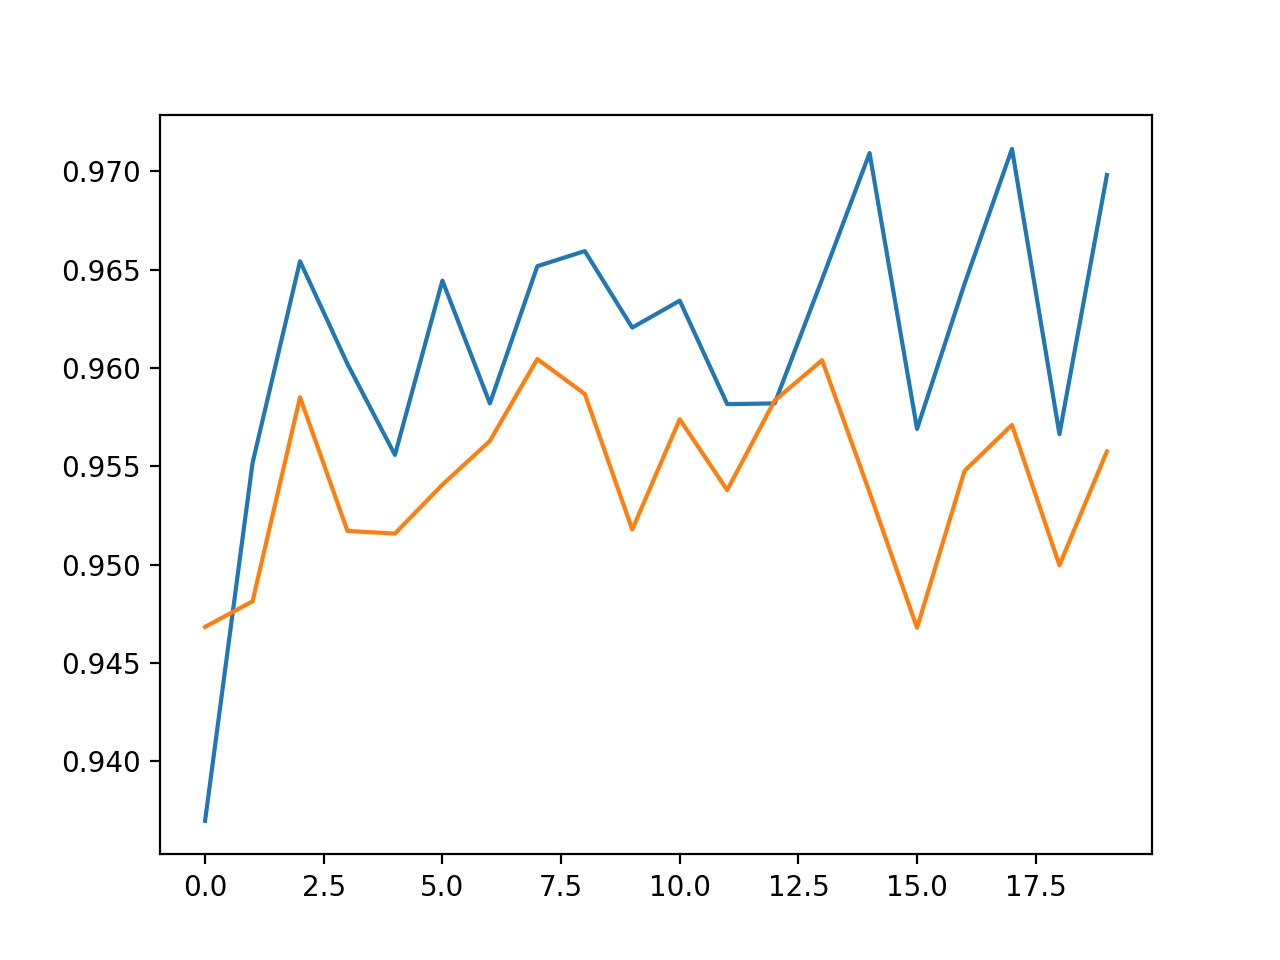

In [12]:
plt.plot(np.mean(accSVM[1,:,:],axis=1))
plt.plot(np.mean(accHDC[1,:,:],axis=1))



<IPython.core.display.Javascript object>


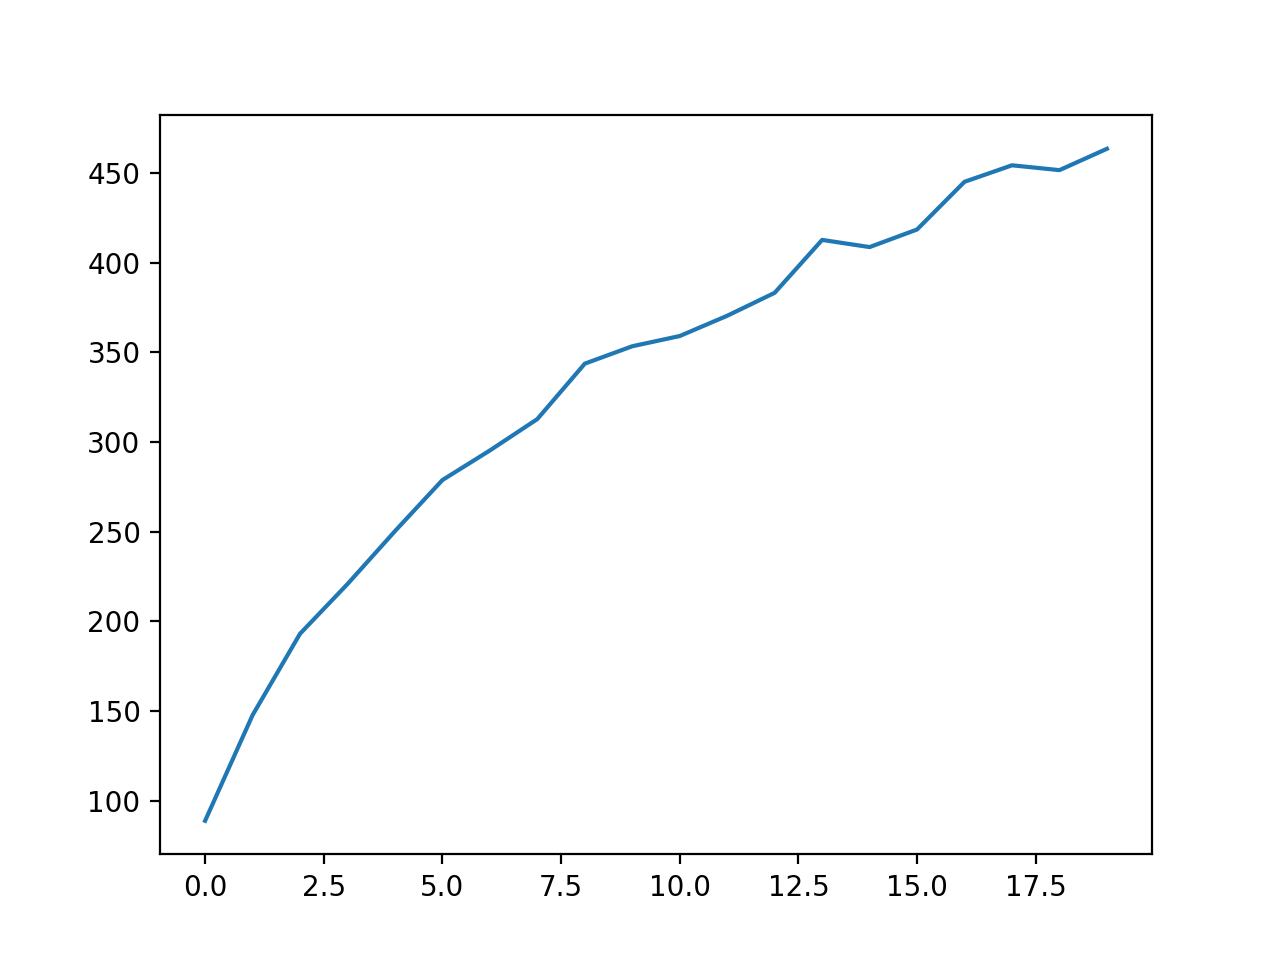

In [13]:
plt.plot(np.mean(numSVM[1,:,:],axis=1))